In [1]:
from IPython.display import HTML
import folium
import random as RD
import pandas as pd
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))

def embed_map(map, path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    map.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))

## Base layer for south

In [3]:
import folium
map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5)
map_osm.geo_json(geo_path = 'data/south.json')
embed_map(map_osm)

/home/serge/anaconda2/lib/python2.7/site-packages/folium/folium.py:504: UserWarning: This method is deprecated. Please use Map.choropleth instead.
  warnings.warn('This method is deprecated. '
/home/serge/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Map.create_map is deprecated. Use Map.save instead


## Binding Attribute Data to the Map

In [4]:
import json

f = open(r'data/south.json')
q = json.load(f)
f.close()

In [5]:
q.keys()

[u'type', u'features']

In [6]:
features = q['features']
len(features)

1412

In [7]:
import pandas as pd
indices = []
values = []
for feature in features:
    indices.append(str(feature['properties']['FIPS']))
    values.append(feature['properties']['HR80'])

In [8]:
df = pd.DataFrame({'HR80': values,
                   'FIPS': indices} )

In [9]:
y = np.array(df.HR80.tolist())

In [10]:
import numpy as np
import pysal as ps
w = ps.queen_from_shapefile('data/south.shp')
w.transform = 'r'

In [11]:
y = np.array(df['HR80'].tolist())

## Local Moran
$li_i = \frac{n-1}{\sum_j z_j^2}z_i \sum_j w_{i,j} z_j$

In [12]:
li_hr80 = ps.Moran_Local(y,w)

In [13]:
li_hr80.p_sim.shape

(1412,)

In [14]:
sig01 = 1.* (li_hr80.p_sim<=0.01)

In [15]:
sig01.sum()

162.0

In [16]:
sig05 = 1.* (li_hr80.p_sim<=0.05)

In [17]:
sig05.sum()

380.0

In [18]:
df['sig01']  = sig01
df['sig05'] = sig05

In [19]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','HR80'],
                 fill_color='YlGnBu', fill_opacity=0.7,
                 line_opacity=0.2,
                 legend_name='Homicide Rate HR80')
embed_map(map_osm)

/home/serge/anaconda2/lib/python2.7/site-packages/folium/folium.py:506: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.
  return self.choropleth(*args, **kwargs)
/home/serge/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [20]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','sig01'],
                 fill_color='YlOrRd', fill_opacity=0.7,
                 line_opacity=0.2,
                 threshold_scale=[0,1],
                 legend_name='Homicide Rate HR80 - Significant LISA (0.01)')
embed_map(map_osm)

/home/serge/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [21]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','sig01'],
                 fill_color='YlOrRd', fill_opacity=0.7,
                 line_opacity=0.2,
                 legend_name='Homicide Rate HR80 - Significant LISA (0.01)')
embed_map(map_osm)

/home/serge/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [22]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','sig05'],
                 fill_color='YlOrRd', fill_opacity=0.7,
                 line_opacity=0.2,
                 legend_name='Homicide Rate HR80 - Significant LISA (0.05)')
embed_map(map_osm)

/home/serge/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [23]:
li_hr80.q

array([3, 3, 3, ..., 3, 3, 3])

In [24]:
cold_spots = 1. * (li_hr80.q==3) * (li_hr80.p_sim < 0.01)

In [25]:
cold_spots.sum()

66.0

In [26]:
# Cold spots in pandas'y way
lisa_df = pd.DataFrame({'q': li_hr80.q, 'p_sim': li_hr80.p_sim})
cold = lisa_df[(lisa_df['q']==3) & (lisa_df['p_sim']<0.01)]
print cold.info()
print '\n~~~~~~~~~~\n'
# Hot spots in pandas'y way
hot = lisa_df[(lisa_df['q']==1) & (lisa_df['p_sim']<0.01)]
print hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 5 to 1286
Data columns (total 2 columns):
p_sim    66 non-null float64
q        66 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.5 KB
None

~~~~~~~~~~

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 199 to 1401
Data columns (total 2 columns):
p_sim    51 non-null float64
q        51 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB
None


In [27]:
hot_spots = 1. * (li_hr80.q==1) * (li_hr80.p_sim < 0.01)

In [28]:
hot_spots.sum()

51.0

In [29]:
df['hot_01'] = hot_spots
df['cold_01'] = cold_spots

In [30]:
df.hot_01

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1382    0
1383    0
1384    0
1385    0
1386    0
1387    0
1388    0
1389    0
1390    0
1391    1
1392    0
1393    0
1394    0
1395    1
1396    0
1397    1
1398    0
1399    1
1400    0
1401    1
1402    0
1403    0
1404    0
1405    0
1406    0
1407    0
1408    0
1409    0
1410    0
1411    0
Name: hot_01, dtype: float64

In [31]:
df.cold_01

0       0
1       0
2       0
3       0
4       0
5       1
6       1
7       0
8       1
9       0
10      1
11      1
12      0
13      0
14      1
15      1
16      1
17      0
18      0
19      1
20      1
21      0
22      1
23      1
24      1
25      0
26      1
27      1
28      1
29      1
       ..
1382    0
1383    0
1384    0
1385    0
1386    0
1387    0
1388    0
1389    0
1390    0
1391    0
1392    0
1393    0
1394    0
1395    0
1396    0
1397    0
1398    0
1399    0
1400    0
1401    0
1402    0
1403    0
1404    0
1405    0
1406    0
1407    0
1408    0
1409    0
1410    0
1411    0
Name: cold_01, dtype: float64

In [32]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','hot_01'],
                 fill_color='YlOrRd', fill_opacity=0.7,
                 line_opacity=0.2,
                 threshold_scale=[0,1],
                 legend_name='Homicide Rate HR80 - Hot Spots (0.01)')
embed_map(map_osm)

/home/serge/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [34]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','cold_01'],
                 fill_color='YlGnBu', fill_opacity=0.7,
                 line_opacity=0.2,
                 threshold_scale=[0,1],
                 legend_name='Homicide Rate HR80 - Cold Spots (0.01)')
embed_map(map_osm)

/home/serge/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [35]:
dbf = ps.open('data/south.dbf')
dbf.header

[u'NAME',
 u'STATE_NAME',
 u'STATE_FIPS',
 u'CNTY_FIPS',
 u'FIPS',
 u'STFIPS',
 u'COFIPS',
 u'FIPSNO',
 u'SOUTH',
 u'HR60',
 u'HR70',
 u'HR80',
 u'HR90',
 u'HC60',
 u'HC70',
 u'HC80',
 u'HC90',
 u'PO60',
 u'PO70',
 u'PO80',
 u'PO90',
 u'RD60',
 u'RD70',
 u'RD80',
 u'RD90',
 u'PS60',
 u'PS70',
 u'PS80',
 u'PS90',
 u'UE60',
 u'UE70',
 u'UE80',
 u'UE90',
 u'DV60',
 u'DV70',
 u'DV80',
 u'DV90',
 u'MA60',
 u'MA70',
 u'MA80',
 u'MA90',
 u'POL60',
 u'POL70',
 u'POL80',
 u'POL90',
 u'DNL60',
 u'DNL70',
 u'DNL80',
 u'DNL90',
 u'MFIL59',
 u'MFIL69',
 u'MFIL79',
 u'MFIL89',
 u'FP59',
 u'FP69',
 u'FP79',
 u'FP89',
 u'BLK60',
 u'BLK70',
 u'BLK80',
 u'BLK90',
 u'GI59',
 u'GI69',
 u'GI79',
 u'GI89',
 u'FH60',
 u'FH70',
 u'FH80',
 u'FH90']

In [36]:
 df['STATE_NAME'] = dbf.by_col('STATE_NAME')

In [37]:
df['County'] = dbf.by_col('NAME')

In [38]:
hot_01 = df['hot_01']

In [39]:
hot  = df[hot_01>0]

In [40]:
hot

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
199,21025,19.603231,1,1,1,0,Kentucky,Breathitt
231,21193,37.516413,1,1,1,0,Kentucky,Perry
240,21051,29.301453,1,1,1,0,Kentucky,Clay
247,21131,38.077319,1,1,1,0,Kentucky,Leslie
285,21095,20.689600,1,1,1,0,Kentucky,Harlan
305,21013,19.419361,1,1,1,0,Kentucky,Bell
712,28027,15.349333,1,1,1,0,Mississippi,Coahoma
804,48387,10.351324,1,1,1,0,Texas,Red River
831,13045,14.197991,1,1,1,0,Georgia,Carroll
850,28015,10.229133,1,1,1,0,Mississippi,Carroll


In [41]:
df[['STATE_NAME', 'County']]

,STATE_NAME,County
0,West Virginia,Hancock
1,West Virginia,Brooke
2,West Virginia,Ohio
3,West Virginia,Marshall
4,Delaware,New Castle
5,Maryland,Washington
6,Maryland,Allegany
7,Maryland,Cecil
8,Maryland,Garrett
9,Maryland,Harford


In [42]:
df.head()

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
0,54029,6.597720,0,0,0,0,West Virginia,Hancock
1,54009,3.213677,0,0,0,0,West Virginia,Brooke
2,54069,7.601796,0,0,0,0,West Virginia,Ohio
3,54051,4.005640,0,0,0,0,West Virginia,Marshall
4,10003,7.116872,0,0,0,0,Delaware,New Castle


In [43]:
df.tail()

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
1407,51083,15.034136,0,0,0,0,Virginia,Halifax
1408,51163,3.967782,0,0,0,0,Virginia,Rockbridge
1409,51161,4.127839,0,0,0,0,Virginia,Roanoke
1410,51199,5.280349,0,0,0,0,Virginia,York
1411,51153,3.000030,0,0,0,0,Virginia,Prince William


In [44]:
df[[0,2,4]]

,FIPS,sig01,hot_01
0,54029,0,0
1,54009,0,0
2,54069,0,0
3,54051,0,0
4,10003,0,0
5,24043,1,0
6,24001,1,0
7,24015,0,0
8,24023,1,0
9,24025,0,0


In [45]:
df[df.hot_01 > 0 ].all()

FIPS           True
HR80           True
sig01          True
sig05          True
hot_01         True
cold_01       False
STATE_NAME     True
County         True
dtype: bool

In [46]:
df[0:10]

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
0,54029,6.597720,0,0,0,0,West Virginia,Hancock
1,54009,3.213677,0,0,0,0,West Virginia,Brooke
2,54069,7.601796,0,0,0,0,West Virginia,Ohio
3,54051,4.005640,0,0,0,0,West Virginia,Marshall
4,10003,7.116872,0,0,0,0,Delaware,New Castle
5,24043,2.063326,1,1,0,1,Maryland,Washington
6,24001,3.724487,1,1,0,1,Maryland,Allegany
7,24015,6.067626,0,0,0,0,Maryland,Cecil
8,24023,5.031826,1,1,0,1,Maryland,Garrett
9,24025,3.426300,0,0,0,0,Maryland,Harford


In [47]:
hot = df[df['hot_01']>0]

In [48]:
hot

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
199,21025,19.603231,1,1,1,0,Kentucky,Breathitt
231,21193,37.516413,1,1,1,0,Kentucky,Perry
240,21051,29.301453,1,1,1,0,Kentucky,Clay
247,21131,38.077319,1,1,1,0,Kentucky,Leslie
285,21095,20.689600,1,1,1,0,Kentucky,Harlan
305,21013,19.419361,1,1,1,0,Kentucky,Bell
712,28027,15.349333,1,1,1,0,Mississippi,Coahoma
804,48387,10.351324,1,1,1,0,Texas,Red River
831,13045,14.197991,1,1,1,0,Georgia,Carroll
850,28015,10.229133,1,1,1,0,Mississippi,Carroll


In [49]:
df[df['hot_01']>0]

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
199,21025,19.603231,1,1,1,0,Kentucky,Breathitt
231,21193,37.516413,1,1,1,0,Kentucky,Perry
240,21051,29.301453,1,1,1,0,Kentucky,Clay
247,21131,38.077319,1,1,1,0,Kentucky,Leslie
285,21095,20.689600,1,1,1,0,Kentucky,Harlan
305,21013,19.419361,1,1,1,0,Kentucky,Bell
712,28027,15.349333,1,1,1,0,Mississippi,Coahoma
804,48387,10.351324,1,1,1,0,Texas,Red River
831,13045,14.197991,1,1,1,0,Georgia,Carroll
850,28015,10.229133,1,1,1,0,Mississippi,Carroll


In [50]:
df[df['cold_01']>0]

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
5,24043,2.063326,1,1,0,1,Maryland,Washington
6,24001,3.724487,1,1,0,1,Maryland,Allegany
8,24023,5.031826,1,1,0,1,Maryland,Garrett
10,54061,4.443023,1,1,0,1,West Virginia,Monongalia
11,54077,1.094331,1,1,0,1,West Virginia,Preston
14,54103,4.571638,1,1,0,1,West Virginia,Wetzel
15,24021,3.194183,1,1,0,1,Maryland,Frederick
16,54065,6.224131,1,1,0,1,West Virginia,Morgan
19,54003,6.413683,1,1,0,1,West Virginia,Berkeley
20,54095,0.000000,1,1,0,1,West Virginia,Tyler


In [51]:
print df[df['cold_01']>0].to_string() 

       FIPS       HR80  sig01  sig05  hot_01  cold_01      STATE_NAME       County
5     24043   2.063326      1      1       0        1        Maryland   Washington
6     24001   3.724487      1      1       0        1        Maryland     Allegany
8     24023   5.031826      1      1       0        1        Maryland      Garrett
10    54061   4.443023      1      1       0        1   West Virginia   Monongalia
11    54077   1.094331      1      1       0        1   West Virginia      Preston
14    54103   4.571638      1      1       0        1   West Virginia       Wetzel
15    24021   3.194183      1      1       0        1        Maryland    Frederick
16    54065   6.224131      1      1       0        1   West Virginia       Morgan
19    54003   6.413683      1      1       0        1   West Virginia     Berkeley
20    54095   0.000000      1      1       0        1   West Virginia        Tyler
22    54037   4.400150      1      1       0        1   West Virginia    Jefferson
23  

In [52]:
hot_01

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1382    0
1383    0
1384    0
1385    0
1386    0
1387    0
1388    0
1389    0
1390    0
1391    1
1392    0
1393    0
1394    0
1395    1
1396    0
1397    1
1398    0
1399    1
1400    0
1401    1
1402    0
1403    0
1404    0
1405    0
1406    0
1407    0
1408    0
1409    0
1410    0
1411    0
Name: hot_01, dtype: float64

In [53]:
y

array([ 6.59772049,  3.21367741,  7.6017962 , ...,  4.12783918,
        5.2803488 ,  3.00003   ])

In [54]:
w = ps.queen_from_shapefile('data/south.shp')
w.transform = 'r'
wy = ps.lag_spatial(w,y)

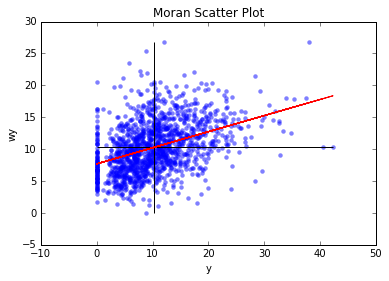

In [55]:
scatter(y,wy, alpha=0.5, lw=0)
vlines(y.mean(),wy.min(),wy.max())
hlines(wy.mean(),y.min(),y.max())
xlabel('y')
ylabel('wy')
lm = ps.spreg.OLS(wy[:, None], y[:, None])
plot(y, lm.predy, color='red')
title('Moran Scatter Plot')
show()

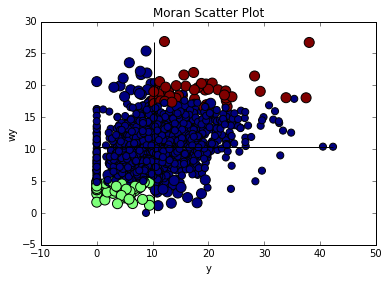

In [56]:
c = 2*hot_01 + df.cold_01
scatter(y,wy, c=c, s=(sig01+1)*50)
vlines(y.mean(),wy.min(),wy.max())
hlines(wy.mean(),y.min(),y.max())
xlabel('y')
ylabel('wy')
title('Moran Scatter Plot')

In [57]:
sig01.sum()

162.0

In [58]:
df['wHR80'] = wy

In [59]:
print df[df['cold_01']>0].to_string() 

       FIPS       HR80  sig01  sig05  hot_01  cold_01      STATE_NAME       County     wHR80
5     24043   2.063326      1      1       0        1        Maryland   Washington  4.669960
6     24001   3.724487      1      1       0        1        Maryland     Allegany  3.153441
8     24023   5.031826      1      1       0        1        Maryland      Garrett  3.527749
10    54061   4.443023      1      1       0        1   West Virginia   Monongalia  2.932325
11    54077   1.094331      1      1       0        1   West Virginia      Preston  3.642804
14    54103   4.571638      1      1       0        1   West Virginia       Wetzel  3.831961
15    24021   3.194183      1      1       0        1        Maryland    Frederick  4.037935
16    54065   6.224131      1      1       0        1   West Virginia       Morgan  3.416385
19    54003   6.413683      1      1       0        1   West Virginia     Berkeley  4.182615
20    54095   0.000000      1      1       0        1   West Virginia 

In [60]:
print df[df['hot_01']>0].to_string() 

       FIPS       HR80  sig01  sig05  hot_01  cold_01   STATE_NAME        County      wHR80
199   21025  19.603231      1      1       1        0     Kentucky     Breathitt  20.213720
231   21193  37.516413      1      1       1        0     Kentucky         Perry  18.053386
240   21051  29.301453      1      1       1        0     Kentucky          Clay  19.064651
247   21131  38.077319      1      1       1        0     Kentucky        Leslie  26.731707
285   21095  20.689600      1      1       1        0     Kentucky        Harlan  20.361694
305   21013  19.419361      1      1       1        0     Kentucky          Bell  19.268191
712   28027  15.349333      1      1       1        0  Mississippi       Coahoma  18.435638
804   48387  10.351324      1      1       1        0        Texas     Red River  19.645064
831   13045  14.197991      1      1       1        0      Georgia       Carroll  16.907577
850   28015  10.229133      1      1       1        0  Mississippi       Carroll

In [61]:
lg = ps.G_Local(y, w)

In [62]:
lg.n

1412

In [63]:
sig = lg.p_sim < 0.01

In [64]:
sig

array([False, False, False, ..., False, False, False], dtype=bool)

In [64]:
lg.p_sim[sig]

array([ 0.002,  0.004,  0.006,  0.002,  0.003,  0.006,  0.007,  0.005,
        0.003,  0.001,  0.007,  0.002,  0.003,  0.001,  0.001,  0.005,
        0.007,  0.003,  0.009,  0.003,  0.005,  0.002,  0.001,  0.004,
        0.009,  0.001,  0.003,  0.006,  0.004,  0.001,  0.009,  0.006,
        0.009,  0.005,  0.002,  0.002,  0.002,  0.001,  0.002,  0.001,
        0.004,  0.001,  0.001,  0.006,  0.001,  0.001,  0.001,  0.006,
        0.001,  0.008,  0.005,  0.006,  0.001,  0.007,  0.006,  0.008,
        0.005,  0.001,  0.005,  0.004,  0.007,  0.002,  0.004,  0.007,
        0.001,  0.003,  0.002,  0.005,  0.003,  0.002,  0.008,  0.004,
        0.004,  0.008,  0.005,  0.004,  0.004,  0.004,  0.004,  0.007,
        0.004,  0.001,  0.001,  0.006,  0.003,  0.004,  0.007,  0.007,
        0.003,  0.001,  0.001,  0.004,  0.006,  0.004,  0.003,  0.001,
        0.001,  0.004,  0.008,  0.002,  0.003,  0.009,  0.007,  0.003,
        0.001,  0.007,  0.004,  0.002,  0.003,  0.001,  0.007,  0.005,
      

In [65]:
lgs = ps.G_Local(y,w, star=True)

In [66]:
lgs.p_sim[lgs.p_sim < 0.01]

array([ 0.009,  0.003,  0.005,  0.007,  0.003,  0.007,  0.008,  0.002,
        0.002,  0.001,  0.001,  0.004,  0.004,  0.001,  0.003,  0.003,
        0.006,  0.007,  0.006,  0.008,  0.002,  0.004,  0.001,  0.001,
        0.005,  0.006,  0.008,  0.001,  0.002,  0.005,  0.004,  0.002,
        0.005,  0.008,  0.009,  0.001,  0.003,  0.001,  0.001,  0.001,
        0.003,  0.001,  0.001,  0.001,  0.002,  0.002,  0.002,  0.007,
        0.001,  0.006,  0.007,  0.005,  0.005,  0.003,  0.006,  0.007,
        0.007,  0.006,  0.002,  0.004,  0.009,  0.002,  0.002,  0.009,
        0.003,  0.002,  0.001,  0.006,  0.001,  0.002,  0.004,  0.005,
        0.002,  0.005,  0.006,  0.002,  0.002,  0.005,  0.005,  0.006,
        0.006,  0.006,  0.001,  0.001,  0.006,  0.004,  0.002,  0.005,
        0.007,  0.002,  0.002,  0.007,  0.008,  0.004,  0.001,  0.004,
        0.001,  0.006,  0.002,  0.004,  0.007,  0.005,  0.001,  0.006,
        0.007,  0.009,  0.004,  0.005,  0.003,  0.005,  0.004,  0.003,
      

In [67]:
sum(sig)

146

In [68]:
sum(lgs.p_sim < 0.01)

146